In [1]:
import os
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

def read_csv_file(fn_csv):
    return pd.read_csv(f'prune_bsol/{fn_csv}', dtype={'bsol': 'str'})

def flip_bsol(bsol:str) -> str:
    if bsol[0] == '1':
        return ''.join(['0' if c == '1' else '1' for c in bsol])
    return bsol

def read_prune_bsol() -> pd.DataFrame:
    csv_files = [fn for fn in os.listdir('prune_bsol') if fn.endswith('.csv')]

    with ProcessPoolExecutor() as executor:
        data = list(tqdm(executor.map(read_csv_file, csv_files), total=len(csv_files)))

    df = pd.concat(data, ignore_index=True)
    df['bsol'] = df['bsol'].apply(flip_bsol)

    df['len_bsol'] = df['bsol'].apply(len)
    return df

In [25]:
df_prune_bsol = read_prune_bsol()
df_prune_bsol.columns

100%|██████████| 73647/73647 [01:01<00:00, 1189.43it/s]


Index(['i', 'j', 'i_name', 'j_name', 'i_residue_number', 'j_residue_number',
       'dij', 'bsol', 'len_bsol'],
      dtype='object')

In [77]:
def create_df_stats(df_prune_bsol:pd.DataFrame, max_length=20) -> pd.DataFrame:
    # frequency relative taking into account the length of the bsol
    df_freq_rel = df_prune_bsol[['len_bsol','bsol','dij']].groupby(['len_bsol','bsol']).count().reset_index()
    # rename columns
    df_freq_rel.rename(columns={'dij':'count'}, inplace=True)
    # total number of bsol for each length
    df_freq_rel['total'] = df_freq_rel.groupby('len_bsol')['count'].transform('sum')
    # frequency relative
    df_freq_rel['freq_rel'] = df_freq_rel['count'] / df_freq_rel['total']
    # sort by length and frequency relative
    df_freq_rel.sort_values(['len_bsol','freq_rel'], ascending=[True,False], inplace=True)
    # length as string
    df_freq_rel['length'] = df_freq_rel['len_bsol'].astype(str)
    # uniform distribution
    # the first bit is fixed to 0 (flip), so the dof is 2^(len_bsol - 1)
    df_freq_rel['uniform'] = 1.0 / (2 ** (df_freq_rel['len_bsol'] - 1))
    # keep only the instances with len_bsol <= 20
    df_freq_rel = df_freq_rel[df_freq_rel['len_bsol'] <= max_length]
    return df_freq_rel

df_stats = create_df_stats(df_prune_bsol)
print(df_stats.shape)
df_stats.head(10)

(9460, 7)


,len_bsol,bsol,count,total,freq_rel,length,uniform
1,2,01,1019138,1458773,0.698627,2,0.500
0,2,00,439635,1458773,0.301373,2,0.500
3,3,001,22071,72075,0.306223,3,0.250
5,3,011,20984,72075,0.291141,3,0.250
2,3,000,15651,72075,0.217149,3,0.250
4,3,010,13369,72075,0.185487,3,0.250
9,4,0011,505874,1370393,0.369145,4,0.125
11,4,0101,199596,1370393,0.145649,4,0.125
8,4,0010,177642,1370393,0.129629,4,0.125
13,4,0111,153378,1370393,0.111923,4,0.125


In [78]:
import plotly.express as px

# scatter, x=len_bsol, y=count, y axis log scale
def plot_count_by_length(df_stats:pd.DataFrame):
    df = df_stats[['len_bsol', 'length', 'total']].groupby(['len_bsol','length']).first().reset_index()
    fig = px.scatter(df, x='length', y='total', log_y=True,
                     title=f"Number of BSOLs",)
    # set size
    fig.update_layout(width=800, height=400)
    fig.show()

plot_count_by_length(df_stats)

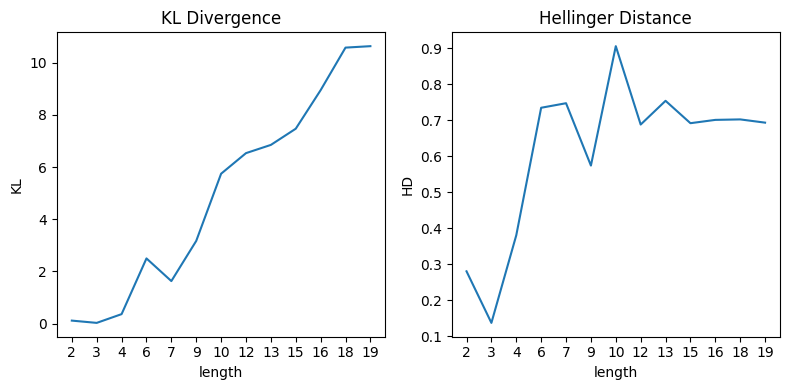

In [99]:
import numpy as np

def plot_stats_measures(df_stats:pd.DataFrame) -> pd.DataFrame:
    # measure KL divergence
    # KL(p||q) = sum(p(x) * log(p(x) / q(x))), where q(x) = 1/2^(len_bsol - 1)
    # Note: 
    #   - The function q is the uniform distribution over all possible BSOLs of length len_bsol.
    #   - The minus 1 is because the first bit is fixed to 0.
    df = df_stats.copy()
    df['KL'] = df_stats.apply(lambda x: x['freq_rel'] * np.log2(x['freq_rel'] / x['uniform']), axis=1)
    # measure Hellinger distance
    df['HD'] = df_stats.apply(lambda x: np.sqrt(0.5 * (x['freq_rel'] - x['uniform']) ** 2), axis=1)
    # sum KL and HD for each length
    df = df.groupby(['len_bsol','length']).sum().reset_index()

    # plot KL, HD, TV using subplots 1 x 3, each one should have its own y axis
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    sns.lineplot(x='length', y='KL', data=df, ax=axs[0])
    axs[0].set_title('KL Divergence')
    sns.lineplot(x='length', y='HD', data=df, ax=axs[1])
    axs[1].set_title('Hellinger Distance')    
    plt.tight_layout()
    plt.show()
    

plot_stats_measures(df_stats)